In [1]:
!mkdir Forest2

In [2]:
!mkdir Forest2/train_images
!mkdir Forest2/train_annotations
!mkdir Forest2/test_images
!mkdir Forest2/test_annotations

In [3]:
import os
import cv2
import xml.etree.ElementTree as ET
from tqdm import tqdm  # A nice progress bar
import matplotlib.pyplot as plt

# --- 1. DEFINE YOUR PATHS ---
# This path now points to your 'Forest2' folder in the Colab root
# (as shown in your screenshot)
base_path = 'Forest2'

train_img_dir = os.path.join(base_path, 'train_images')
train_ann_dir = os.path.join(base_path, 'train_annotations')

# This is where your new, processed images will be saved
output_dir = os.path.join(base_path, 'processed_data')
os.makedirs(output_dir, exist_ok=True) # Create the folder if it doesn't exist

# Define your target size for the model
TARGET_SIZE = (224, 224) # Standard for many models like ResNet, VGG

# --- 2. UPDATED PARSING FUNCTION ---
# This is now customized for your XML structure
def parse_annotation(ann_path):
    """
    Parses your specific XML annotation file.
    The label is extracted from the <damage> tag.
    Returns: list of tuples, e.g., [ ('LD', [72, 76, 257, 257]), ... ]
    """
    annotations = []
    try:
        tree = ET.parse(ann_path)
        root = tree.getroot()

        # Loop through each <object> tag
        for obj in root.findall('object'):
            # The label is the text inside the <damage> tag
            label = obj.find('damage').text

            bbox = obj.find('bndbox')
            xmin = int(bbox.find('xmin').text)
            ymin = int(bbox.find('ymin').text)
            xmax = int(bbox.find('xmax').text)
            ymax = int(bbox.find('ymax').text)

            # Append the label (e.g., 'LD' or 'H') and its coordinates
            annotations.append((label, [xmin, ymin, xmax, ymax]))

    except Exception as e:
        print(f"Error parsing {ann_path}: {e}")

    return annotations

# --- 3. MAIN PROCESSING LOOP ---
# We will loop through images and find matching .xml annotations

print("Starting data processing...")

# Get list of all image files (your screenshot shows uppercase .JPG)
image_files = [f for f in os.listdir(train_img_dir) if f.endswith('.JPG')]

if not image_files:
     print(f"No .JPG files found in {train_img_dir}.")
     print("Please check file extensions (e.g., are they .jpg, .png?).")

for img_filename in tqdm(image_files): # tqdm gives you a nice progress bar

    # Get the file's base name (e.g., "B04_0034")
    base_name = os.path.splitext(img_filename)[0]

    # Define the full paths for the image and annotation files
    img_path = os.path.join(train_img_dir, img_filename)

    # Assume the annotation file has the same base name, but with .xml
    ann_path = os.path.join(train_ann_dir, base_name + '.xml')

    # Check if the matching annotation file exists
    if not os.path.exists(ann_path):
        print(f"Warning: No matching annotation found for {img_filename}")
        continue

    # 1. Read the original image
    # We use cv2.imread which reads in BGR format
    image = cv2.imread(img_path)
    if image is None:
        print(f"Warning: Could not read image {img_path}")
        continue

    # 2. Get the crop coordinates from the annotation file
    annotations = parse_annotation(ann_path)

    # 3. Loop through all objects (crops) found in the annotation
    for i, (label, box) in enumerate(annotations):
        # 3a. Get coordinates
        xmin, ymin, xmax, ymax = box

        # 3b. CROP the image
        # Note: OpenCV uses [y:y, x:x] indexing
        cropped_image = image[ymin:ymax, xmin:xmax]

        if cropped_image.size == 0:
            print(f"Warning: Bad crop coordinates in {ann_path} (img: {img_filename})")
            continue

        # 3c. RESIZE the cropped image
        resized_image = cv2.resize(cropped_image, TARGET_SIZE)

        # 3d. Create the output directory for this label (e.g., "processed_data/LD")
        label_dir = os.path.join(output_dir, label)
        os.makedirs(label_dir, exist_ok=True)

        # 3e. SAVE the new, processed image
        # We add a suffix '_i' in case one image has multiple objects
        output_filename = f"{base_name}_{i}.jpg"
        save_path = os.path.join(label_dir, output_filename)
        cv2.imwrite(save_path, resized_image)

print("---")
print(f"Processing complete! 🚀")
print(f"Your new, processed dataset is ready in: {output_dir}")

Starting data processing...


100%|██████████| 168/168 [00:14<00:00, 11.26it/s]

---
Processing complete! 🚀
Your new, processed dataset is ready in: Forest2/processed_data


In [4]:
import torch
from torch.utils.data import DataLoader, random_split, WeightedRandomSampler, Subset
from torchvision import datasets, transforms
import numpy as np

# --- 1. Define the SIMPLE Transforms (from your 85.5% run) ---
IMG_SIZE = 224
data_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)), # Back to simple Resize
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# --- 2. Load Datasets and Create Indices ---
data_dir = 'Forest2/processed_data'

# We only need one dataset instance since transforms are the same
full_dataset = datasets.ImageFolder(data_dir, transform=data_transforms)

# Get total size and create a shuffled list of indices
num_samples = len(full_dataset)
indices = list(range(num_samples))
np.random.seed(123) # for reproducible splits
np.random.shuffle(indices)

# Get split point
split = int(0.8 * num_samples)
train_idx, val_idx = indices[:split], indices[split:]

# --- 3. Create Subset objects ---
train_dataset = Subset(full_dataset, train_idx)
val_dataset = Subset(full_dataset, val_idx)

# --- 4. Create the Weighted Sampler ---
train_labels = [full_dataset.targets[i] for i in train_idx]
# --- THIS IS THE FIX ---
class_counts = torch.bincount(torch.tensor(train_labels)) # Was torch.bount
# --- END FIX ---
class_weights = 1. / class_counts.float()
sample_weights = class_weights[train_labels]

sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True
)

# --- 5. Create Final DataLoaders ---
BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=sampler)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Get Class Names and Device
class_names = full_dataset.classes
num_classes = len(class_names)
print(f"Data re-loaded with SIMPLE transforms.")
print(f"Classes: {class_names}")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Training on device: {device}")

Data re-loaded with SIMPLE transforms.
Classes: ['H', 'HD', 'LD', 'other']
Training on device: cuda:0


In [8]:
from torchvision import models
import torch.nn as nn
import torch.optim as optim
# --- 1. Load the Pre-trained *ResNet50* Model ---
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)

# --- 2. Freeze the early layers ---
for param in model.parameters():
    param.requires_grad = False

# --- 3. Unfreeze the LATER layers (layer3, layer4, and fc) ---
for param in model.layer3.parameters():
    param.requires_grad = True
for param in model.layer4.parameters():
    param.requires_grad = True

# --- 4. Replace the Final Layer (with Dropout) ---
num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    # NEW: Add a Dropout layer to fight overfitting
    nn.Dropout(0.5),
    nn.Linear(num_ftrs, num_classes)
)
model.fc.requires_grad = True

model = model.to(device)

# --- 5. Define Loss Function and Optimizer (with Weight Decay) ---
# This assumes 'class_weights' and 'device' were defined in the previous cell
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))

params_to_update = []
for param in model.parameters():
    if param.requires_grad:
        params_to_update.append(param)

# NEW: Add 'weight_decay' to the optimizer
optimizer = optim.Adam(params_to_update, lr=1e-4, weight_decay=1e-5)

print("Model built: ResNet50 (Partial Fine-Tuning + Dropout + Weight Decay)")
print("--- Using a WEIGHTED LOSS function ---")

Model built: ResNet50 (Partial Fine-Tuning + Dropout + Weight Decay)
--- Using a WEIGHTED LOSS function ---


In [9]:
import copy # We need this to save the best model weights

# --- 1. Define Epochs & Tracking Variables ---
NUM_EPOCHS = 20 # Train for longer
best_val_acc = 0.0 # Track the best score
best_model_wts = copy.deepcopy(model.state_dict()) # Store the best weights

print("Starting training with Early Stopping...")

# --- 2. RUN THE TRAINING LOOP ---
for epoch in range(NUM_EPOCHS):
    # --- Training Phase ---
    model.train()
    running_loss = 0.0
    running_corrects = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = running_corrects.double() / len(train_dataset)

    # --- Validation Phase ---
    model.eval()
    val_loss = 0.0
    val_corrects = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            val_corrects += torch.sum(preds == labels.data)

    val_loss = val_loss / len(val_dataset)
    val_acc = val_corrects.double() / len(val_dataset)

    print(f'Epoch {epoch+1}/{NUM_EPOCHS} | Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} | Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}')

    # --- NEW: Early Stopping Logic ---
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_wts = copy.deepcopy(model.state_dict())
        print(f"** New best model saved! (Epoch {epoch+1}) **")

    print('-' * 20)

print('Training complete! 🚀')
print(f'Best Validation Accuracy: {best_val_acc:.4f}')

# --- 3. Load the best model weights back into the 'model' object ---
model.load_state_dict(best_model_wts)
print("Loaded best model weights from epoch with highest validation accuracy.")

Starting training with Early Stopping...
Epoch 1/20 | Train Loss: 0.2048 Acc: 0.8312 | Val Loss: 0.3961 Acc: 0.6776
** New best model saved! (Epoch 1) **
--------------------
Epoch 2/20 | Train Loss: 0.1111 Acc: 0.8946 | Val Loss: 0.4116 Acc: 0.7475
** New best model saved! (Epoch 2) **
--------------------
Epoch 3/20 | Train Loss: 0.0771 Acc: 0.9265 | Val Loss: 0.4527 Acc: 0.7475
--------------------
Epoch 4/20 | Train Loss: 0.0609 Acc: 0.9438 | Val Loss: 0.5370 Acc: 0.8258
** New best model saved! (Epoch 4) **
--------------------
Epoch 5/20 | Train Loss: 0.0461 Acc: 0.9562 | Val Loss: 0.5252 Acc: 0.8227
--------------------
Epoch 6/20 | Train Loss: 0.0425 Acc: 0.9605 | Val Loss: 0.4474 Acc: 0.8241
--------------------
Epoch 7/20 | Train Loss: 0.0389 Acc: 0.9634 | Val Loss: 0.5151 Acc: 0.8160
--------------------
Epoch 8/20 | Train Loss: 0.0280 Acc: 0.9733 | Val Loss: 0.4912 Acc: 0.8608
** New best model saved! (Epoch 8) **
--------------------
Epoch 9/20 | Train Loss: 0.0289 Acc: 0.

In [10]:
import os
import cv2
import xml.etree.ElementTree as ET
from tqdm import tqdm

print("Processing TEST data...")

# --- 1. DEFINE YOUR *TEST* PATHS ---
base_path = 'Forest2'

test_img_dir = os.path.join(base_path, 'test_images')
test_ann_dir = os.path.join(base_path, 'test_annotations')

# This is where your new, processed TEST images will be saved
output_test_dir = os.path.join(base_path, 'processed_test_data')
os.makedirs(output_test_dir, exist_ok=True)

# --- 2. RE-USE THE PARSING FUNCTION ---
# (We already defined this, but include it for completeness if in a new session)
def parse_annotation(ann_path):
    annotations = []
    try:
        tree = ET.parse(ann_path)
        root = tree.getroot()
        for obj in root.findall('object'):
            label = obj.find('damage').text
            bbox = obj.find('bndbox')
            xmin = int(bbox.find('xmin').text)
            ymin = int(bbox.find('ymin').text)
            xmax = int(bbox.find('xmax').text)
            ymax = int(bbox.find('ymax').text)
            annotations.append((label, [xmin, ymin, xmax, ymax]))
    except Exception as e:
        print(f"Error parsing {ann_path}: {e}")
    return annotations

# --- 3. MAIN PROCESSING LOOP FOR *TEST* DATA ---
# Get list of all image files
image_files = [f for f in os.listdir(test_img_dir) if f.endswith('.JPG')]

for img_filename in tqdm(image_files):

    base_name = os.path.splitext(img_filename)[0]
    img_path = os.path.join(test_img_dir, img_filename)
    ann_path = os.path.join(test_ann_dir, base_name + '.xml')

    if not os.path.exists(ann_path):
        print(f"Warning: No matching annotation found for {img_filename}")
        continue

    image = cv2.imread(img_path)
    if image is None:
        continue

    annotations = parse_annotation(ann_path)

    for i, (label, box) in enumerate(annotations):
        xmin, ymin, xmax, ymax = box
        cropped_image = image[ymin:ymax, xmin:xmax]

        if cropped_image.size == 0:
            continue

        resized_image = cv2.resize(cropped_image, (IMG_SIZE, IMG_SIZE)) # Use IMG_SIZE from before

        # Create output directory for this label
        label_dir = os.path.join(output_test_dir, label)
        os.makedirs(label_dir, exist_ok=True)

        # Save the new, processed image
        output_filename = f"{base_name}_{i}.jpg"
        save_path = os.path.join(label_dir, output_filename)
        cv2.imwrite(save_path, resized_image)

print("---")
print(f"TEST data processing complete!")
print(f"Processed test data saved to: {output_test_dir}")

Processing TEST data...


100%|██████████| 11/11 [00:00<00:00, 15.31it/s]

---
TEST data processing complete!
Processed test data saved to: Forest2/processed_test_data


In [11]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# --- 1. Load the Test Data ---
test_data_dir = 'Forest2/processed_test_data'

# Use the *same* transforms as before
test_dataset = datasets.ImageFolder(test_data_dir, transform=data_transforms)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Loaded {len(test_dataset)} test images.")

# --- 2. Run Evaluation ---
model.eval() # Set model to evaluation mode (very important!)

all_preds = []
all_labels = []

with torch.no_grad(): # Disable gradient calculation
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        # Store predictions and labels to analyze later
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# --- 3. Print Results ---
# 'class_names' should be from your training script: ['H', 'LD', ...]
print("\n--- Test Results ---")

# Overall Accuracy
accuracy = np.sum(np.array(all_preds) == np.array(all_labels)) / len(all_labels)
print(f"Overall Test Accuracy: {accuracy * 100:.2f}%")

print("\n--- Classification Report ---")
# This gives you precision, recall, and f1-score for each class
report = classification_report(all_labels, all_preds, target_names=class_names)
print(report)

print("\n--- Confusion Matrix ---")
# This shows you *where* the model is getting confused
# Rows are the TRUE label, Columns are the PREDICTED label
cm = confusion_matrix(all_labels, all_preds)
print(cm)

Loaded 731 test images.

--- Test Results ---
Overall Test Accuracy: 86.05%

--- Classification Report ---
              precision    recall  f1-score   support

           H       0.46      0.27      0.34        22
          HD       0.75      0.87      0.80       172
          LD       0.90      0.84      0.87       405
       other       0.95      0.99      0.97       132

    accuracy                           0.86       731
   macro avg       0.76      0.75      0.75       731
weighted avg       0.86      0.86      0.86       731


--- Confusion Matrix ---
[[  6   0  16   0]
 [  0 150  21   1]
 [  7  50 342   6]
 [  0   1   0 131]]


Confusion matrix heatmap saved as final_confusion_matrix.png


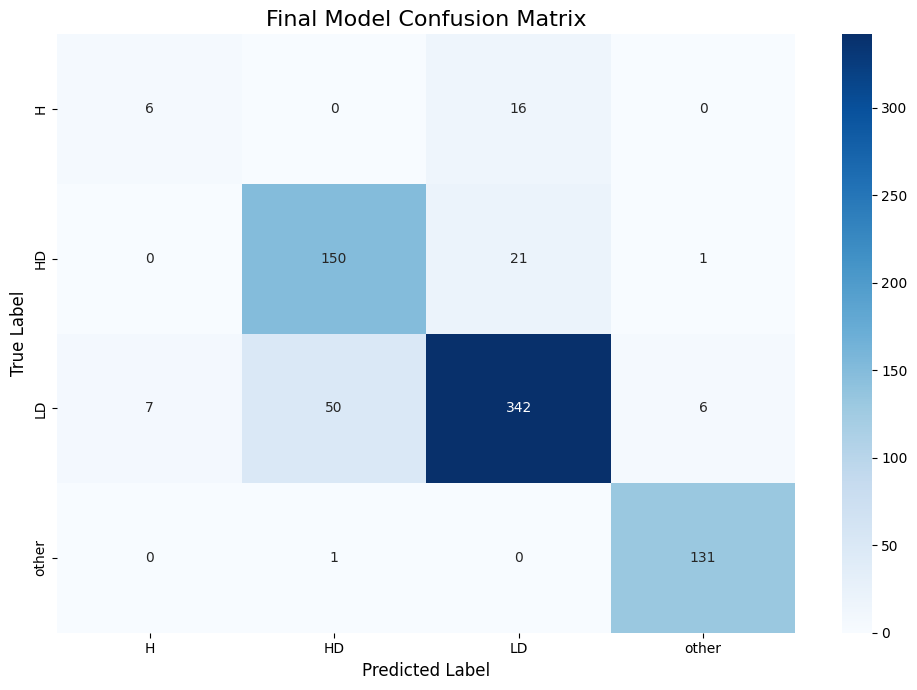

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import confusion_matrix

# This assumes you have:
# 'all_labels': A list of the true labels from your test set
# 'all_preds': A list of the predicted labels from your model
# 'class_names': The list of your class names (e.g., ['H', 'HD', 'LD', 'other'])

# 1. Calculate the confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# 2. Create a DataFrame for Seaborn
cm_df = pd.DataFrame(cm,
                     index=class_names,
                     columns=class_names)

# 3. Plot the heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(cm_df,
            annot=True,     # Show the numbers in each cell
            fmt='d',        # Format as integers
            cmap='Blues')   # Use a blue color scheme
plt.title('Final Model Confusion Matrix', fontsize=16)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()

# Save the plot
plt.savefig('final_confusion_matrix.png')
print("Confusion matrix heatmap saved as final_confusion_matrix.png")

Random prediction plot saved as random_predictions.png


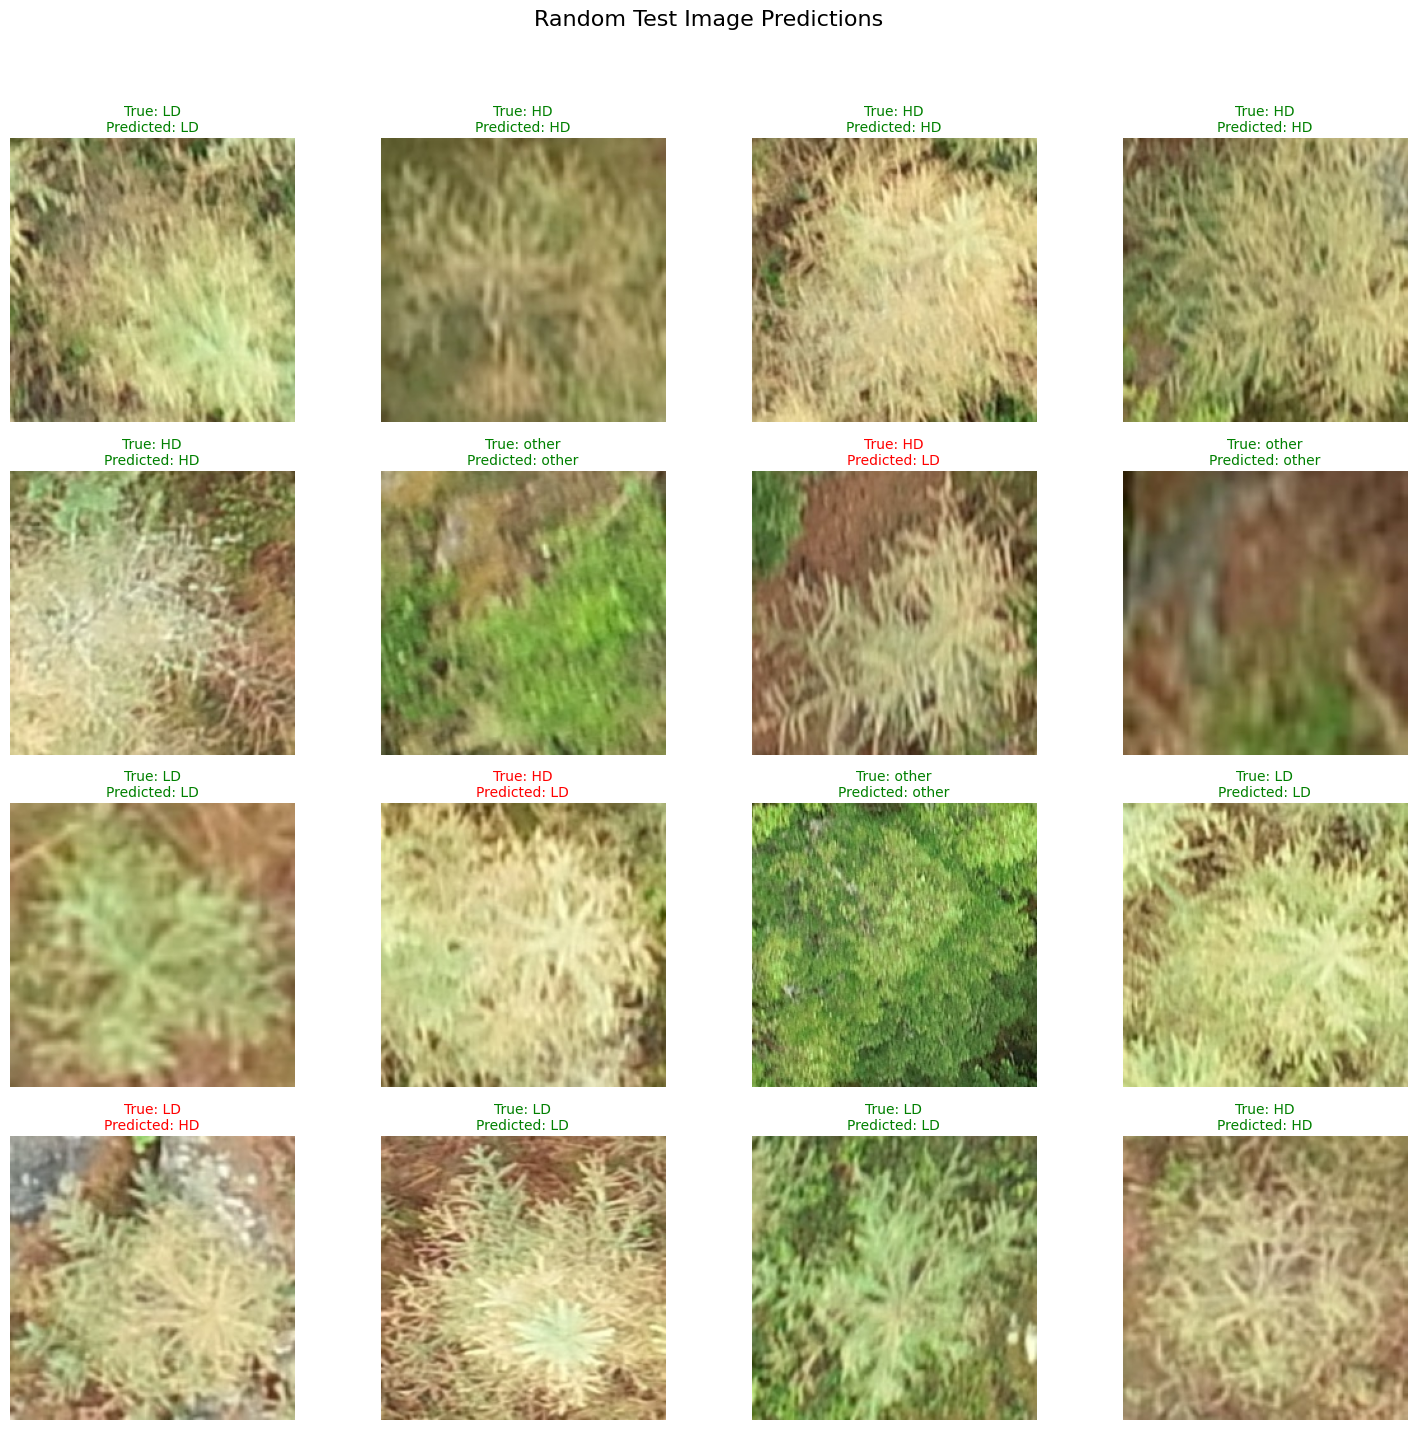

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# --- 1. Helper function to un-normalize and display an image ---
# (This is the same function as before)
def imshow(inp, title=None):
    """Utility function to display a PyTorch tensor as an image."""
    inp = inp.numpy().transpose((1, 2, 0)) # Re-order from [C, H, W] to [H, W, C]
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1) # Ensure pixel values are between 0 and 1

    plt.imshow(inp)
    if title is not None:
        plt.title(title, wrap=True, fontsize=10)
    plt.axis('off')

# --- 2. FIX: Re-create the Test Loader ---
# This ensures the loader is not exhausted from the previous evaluation cell
test_data_dir = 'Forest2/processed_test_data'
# We use 'data_transforms' from your previous cell (the simple 85.5% one)
test_dataset = datasets.ImageFolder(test_data_dir, transform=data_transforms)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True) # Batch of 16, shuffled

# --- 3. Get one batch of random test images ---
model.eval() # Set model to evaluation mode
inputs, labels = next(iter(test_loader)) # Get one batch

# --- 4. Get predictions for that batch ---
inputs_device = inputs.to(device)
labels_device = labels.to(device)
with torch.no_grad():
    outputs = model(inputs_device)
    _, preds = torch.max(outputs, 1)

# Move data back to CPU for plotting
inputs_cpu = inputs.cpu()
labels_cpu = labels.cpu().numpy()
preds_cpu = preds.cpu().numpy()

# --- 5. Plot the images with their predictions ---
num_to_show = 16 # Show 16 images in a 4x4 grid
plt.figure(figsize=(15, 15))
plt.suptitle('Random Test Image Predictions', fontsize=16)

for i in range(num_to_show):
    plt.subplot(4, 4, i + 1)

    true_label = class_names[labels_cpu[i]]
    pred_label = class_names[preds_cpu[i]]

    # Add a visual cue: green if correct, red if incorrect
    title_color = 'green' if true_label == pred_label else 'red'
    title_text = f"True: {true_label}\nPredicted: {pred_label}"

    imshow(inputs_cpu[i], title_text)
    plt.gca().title.set_color(title_color) # Set the title color

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('random_predictions.png')
print("Random prediction plot saved as random_predictions.png")